<a href="https://colab.research.google.com/github/ftk1000/w2v_ftk1000/blob/master/w2v_d2l_pretraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

w2v_d2l_pretraining.ipynb

http://d2l.ai/chapter_natural-language-processing-pretraining/word2vec-pretraining.html

The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install d2l==0.16.2


     |████████████████████████████████| 81kB 8.2MB/s 


# Pretraining word2vec
:label:`sec_word2vec_pretraining`

In this section, we will train a skip-gram model defined in
:numref:`sec_word2vec`.

First, import the packages and modules required for the experiment, and load the PTB dataset.


In [2]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = d2l.load_data_ptb(batch_size, max_window_size,
                                     num_noise_words)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## The Skip-Gram Model

We will implement the skip-gram model by using embedding layers and minibatch multiplication. These methods are also often used to implement other natural language processing applications.

### Embedding Layer

As described in :numref:`sec_seq2seq`,
The layer in which the obtained word is embedded is called the embedding layer, which can be obtained by creating an `nn.Embedding` instance in high-level APIs. The weight of the embedding layer is a matrix whose number of rows is the dictionary size (`input_dim`) and whose number of columns is the dimension of each word vector (`output_dim`). We set the dictionary size to $20$ and the word vector dimension to $4$.


In [3]:
embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
print(f'Parameter embedding_weight ({embed.weight.shape}, '
      'dtype={embed.weight.dtype})')

Parameter embedding_weight (torch.Size([20, 4]), dtype={embed.weight.dtype})


The input of the embedding layer is the index of the word. When we enter the index $i$ of a word, the embedding layer returns the $i^\mathrm{th}$ row of the weight matrix as its word vector. Below we enter an index of shape ($2$, $3$) into the embedding layer. Because the dimension of the word vector is 4, we obtain a word vector of shape ($2$, $3$, $4$).


In [4]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]])
embed(x)

tensor([[[-0.3538, -0.1557,  0.1149, -1.3859],
         [ 0.5843, -1.7524, -0.1120, -0.3392],
         [ 0.5273, -0.2884, -0.3866,  1.4555]],

        [[-0.7101, -0.5256,  1.2139, -0.9678],
         [-1.3683,  0.7625, -0.4991, -0.2273],
         [ 1.4980,  1.0929, -0.5034, -0.0184]]], grad_fn=<EmbeddingBackward>)

### Skip-gram Model Forward Calculation

In forward calculation, the input of the skip-gram model contains the central target word index `center` and the concatenated context and noise word index `contexts_and_negatives`. In which, the `center` variable has the shape (batch size, 1), while the `contexts_and_negatives` variable has the shape (batch size, `max_len`). These two variables are first transformed from word indexes to word vectors by the word embedding layer, and then the output of shape (batch size, 1, `max_len`) is obtained by minibatch multiplication. Each element in the output is the inner product of the central target word vector and the context word vector or noise word vector.


In [5]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

Verify that the output shape should be (batch size, 1, `max_len`).


In [6]:
skip_gram(torch.ones((2, 1), dtype=torch.long),
          torch.ones((2, 4), dtype=torch.long), embed, embed).shape

torch.Size([2, 1, 4])

## Training

Before training the word embedding model, we need to define the loss function of the model.

### Binary Cross Entropy Loss Function

According to the definition of the loss function in negative sampling, we can directly use the binary cross-entropy loss function from high-level APIs.


In [7]:
class SigmoidBCELoss(nn.Module):
    "BCEWithLogitLoss with masking on call."

    def __init__(self):
        super().__init__()

    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none")
        return out.mean(dim=1)

loss = SigmoidBCELoss()

It is worth mentioning that we can use the mask variable to specify the partial predicted value and label that participate in loss function calculation in the minibatch: when the mask is 1, the predicted value and label of the corresponding position will participate in the calculation of the loss function; When the mask is 0, they do not participate. As we mentioned earlier, mask variables can be used to avoid the effect of padding on loss function calculations.

Given two identical examples, different masks lead to different loss values.


In [8]:
pred = torch.tensor([[.5] * 4] * 2)
label = torch.tensor([[1., 0., 1., 0.]] * 2)
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])
loss(pred, label, mask)

tensor([0.7241, 0.3620])

We can normalize the loss in each example due to various lengths in each example.


In [9]:
loss(pred, label, mask) / mask.sum(axis=1) * mask.shape[1]

tensor([0.7241, 0.7241])

### Initializing Model Parameters

We construct the embedding layers of the central and context words, respectively, and set the hyperparameter word vector dimension `embed_size` to 100.


In [10]:
embed_size = 100
net = nn.Sequential(
    nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_size),
    nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_size))

### Training

The training function is defined below. Because of the existence of padding, the calculation of the loss function is slightly different compared to the previous training functions.


In [11]:
def train(net, data_iter, lr, num_epochs, device=d2l.try_gpu()):
    def init_weights(m):
        if type(m) == nn.Embedding:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs])
    metric = d2l.Accumulator(2)  # Sum of losses, no. of tokens
    for epoch in range(num_epochs):
        timer, num_batches = d2l.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [
                data.to(device) for data in batch]

            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (
                loss(pred.reshape(label.shape).float(), label.float(), mask) /
                mask.sum(axis=1) * mask.shape[1])
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

Now, we can train a skip-gram model using negative sampling.


loss 0.305, 2284961.2 tokens/sec on cuda:0


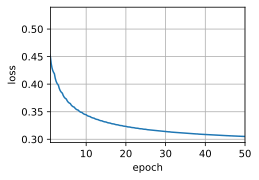

In [25]:
lr, num_epochs = 0.01, 50
train(net, data_iter, lr, num_epochs)

## Applying the Word Embedding Model

After training the word embedding model, we can represent similarity in meaning between words based on the cosine similarity of two word vectors. As we can see, when using the trained word embedding model, the words closest in meaning to the word "chip" are mostly related to chips.


In [26]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]
    # Compute the cosine similarity. Add 1e-9 for numerical stability
    cos = torch.mv(
        W, x) / torch.sqrt(torch.sum(W * W, dim=1) * torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k + 1)[1].cpu().numpy().astype('int32')
    for i in topk[1:]:  # Remove the input words
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.idx_to_token[i]}')

get_similar_tokens('chip', 3, net[0])

cosine sim=0.519: bugs
cosine sim=0.481: intel
cosine sim=0.474: microprocessor


## Summary

* We can pretrain a skip-gram model through negative sampling.


## Exercises

1. Set `sparse_grad=True` when creating an instance of `nn.Embedding`. Does it accelerate training? Look up MXNet documentation to learn the meaning of this argument.
1. Try to find synonyms for other words.
1. Tune the hyperparameters and observe and analyze the experimental results.
1. When the dataset is large, we usually sample the context words and the noise words for the central target word in the current minibatch only when updating the model parameters. In other words, the same central target word may have different context words or noise words in different epochs. What are the benefits of this sort of training? Try to implement this training method.


[Discussions](https://discuss.d2l.ai/t/1335)


# More experiments

In [35]:
print(len(vocab.idx_to_token))
vocab.idx_to_token[-20:]

6719


['superfund',
 'diamonds',
 'berry',
 'rubbermaid',
 'dec',
 'boiler',
 'merabank',
 'palladium',
 'less-developed',
 'nuovo',
 'brawer',
 'air-freight',
 'lufthansa',
 'winnebago',
 'u',
 'soo',
 'furriers',
 'westmoreland',
 'gin',
 'gelbart']

In [34]:
get_similar_tokens('gold', 3, net[0])

cosine sim=0.478: ounce
cosine sim=0.455: platinum
cosine sim=0.434: lows
